In [6]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score


df_global = pd.read_csv('../Data/global.csv', encoding='ISO-8859-1')
df_without_norm = pd.read_csv('../Data/global_preprocessed_without_onehot_and_norm.csv')
df = pd.read_csv('../Data/global_preprocessed_without_onehot.csv', encoding='ISO-8859-1')
#df_without_norm = df_without_norm[:df_without_norm.shape[0]//10]
#df = df[:df.shape[0]//10]

dfh = df[:df.shape[0]//10]
df_without_normh = df_without_norm[:df_without_norm.shape[0]//10]
#df = df[:df.shape[0]//10]
#df_without_norm = df_without_norm[:df_without_norm.shape[0]//10]

/tmp/ipykernel_7332/2389776470.py:9: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df_global = pd.read_csv('../Data/global.csv', encoding='ISO-8859-1')


In [7]:
df_global.rename(columns={'gname': 'gname_txt'}, inplace=True)
df_global['gname'] = pd.factorize(df_global['gname_txt'])[0]
attacktype_dict = dict(zip(df_global['attacktype1'], df_global['attacktype1_txt']))
targettype_dict = dict(zip(df_global['targtype1'], df_global['targtype1_txt']))
region_dict = dict(zip(df_global['region'], df_global['region_txt']))
gname_dict = dict(zip(df_global['gname'], df_global['gname_txt']))

GridSearch for KMeans clustering

In [8]:
# Define the parameter grid
k_values = range(2, 15)   

# Store silhouette scores and k values
silhouette_scores = []
k_values_used = []
kmeans_array = []
# Perform "Grid Search"
for k in k_values:
    print("K: " + str(k))
    kmeans_i = KMeans(n_clusters=k, random_state=0, n_init='auto', max_iter=100)
    kmeans_i.fit(df)
    score = silhouette_score(df, kmeans_i.labels_,  sample_size=1000)
    silhouette_scores.append(score)
    kmeans_array.append(kmeans_i)
    k_values_used.append(k)

K: 2
K: 3
K: 4
K: 5
K: 6
K: 7
K: 8
K: 9
K: 10
K: 11
K: 12
K: 13
K: 14


Best k: 2


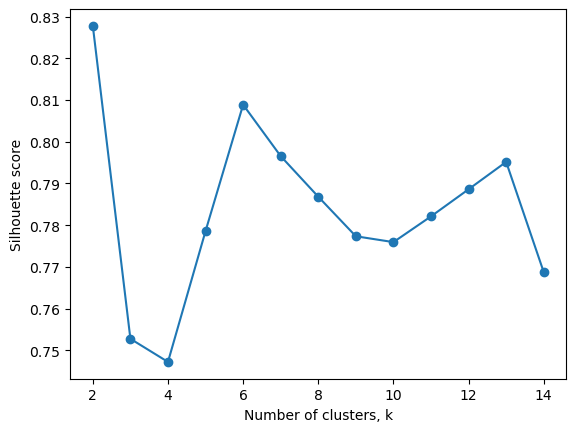

In [9]:
# Determine the best k
best_k = k_values_used[silhouette_scores.index(max(silhouette_scores))]
kmeans = kmeans_array[silhouette_scores.index(max(silhouette_scores))]
print('Best k:', best_k)

# Plot
plt.plot(k_values_used, silhouette_scores, marker='o')
plt.xlabel("Number of clusters, k")
plt.ylabel("Silhouette score")
plt.show()

In [12]:
df['KMeans_labels'] = kmeans.labels_
df_without_norm['KMeans_labels'] = kmeans.labels_

In [13]:
eps_vals = np.linspace(0.3, 1.5, 10)
min_samples_vals = range(10, 100, 500)

best_score = -1
best_eps = None
best_dbscan = None
best_min_samples = None


GridSearch for DBSCAN clustering

In [14]:
# DBSCAN clustering
for eps in eps_vals:
    print("Eps: " + str(eps))
    for min_samples in min_samples_vals:
        print("Min samples: " + str(min_samples))
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        
        # Fit the model
        labels = dbscan.fit_predict(df)
        
        # Ignore cases where the clustering resulted in only one cluster or noise
        if len(np.unique(labels)) > 1:
            score = silhouette_score(df, labels, sample_size=1000)
            
            # If the silhouette score is better, store these parameters as the best
            if score > best_score:
                best_dbscan = dbscan
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

Eps: 0.3
Min samples: 10
Eps: 0.43333333333333335
Min samples: 10
Eps: 0.5666666666666667
Min samples: 10
Eps: 0.7
Min samples: 10
Eps: 0.8333333333333333
Min samples: 10
Eps: 0.9666666666666666
Min samples: 10
Eps: 1.1
Min samples: 10
Eps: 1.2333333333333334
Min samples: 10
Eps: 1.3666666666666667
Min samples: 10
Eps: 1.5
Min samples: 10


Best params for DBSCAN clustering

In [19]:
print("Best eps: " + str(best_eps))
print("Best score: " + str(best_score))
print("Best min samples: " + str(best_min_samples))

Best eps: 1.5
Best score: 0.04546936985788387
Best min samples: 10


In [20]:
dbscan = best_dbscan
df['DBSCAN_labels'] = dbscan.labels_
df_without_norm['DBSCAN_labels'] = dbscan.labels_

Hierarchical clustering

In [35]:
try:
    # Hierarchical clustering
    agg_clustering = AgglomerativeClustering(n_clusters=best_k)
    agg_clustering.fit(dfh)
    dfh['Hierarchical_labels'] = agg_clustering.labels_
    df_without_normh['Hierarchical_labels'] = agg_clustering.labels_
except:
    pass

/tmp/ipykernel_7332/2421614822.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfh['Hierarchical_labels'] = agg_clustering.labels_
/tmp/ipykernel_7332/2421614822.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_normh['Hierarchical_labels'] = agg_clustering.labels_


Evaluation of KMeans, DBSCAN and Hierarchical models

In [36]:
print(f"KMeans silhouette score: {silhouette_score(df, kmeans.labels_, sample_size=1000):.2f}")
print(f"DBSCAN silhouette score: {silhouette_score(df, dbscan.labels_, sample_size=1000):.2f}")
try:
    print(f"Hierarchical silhouette score: {silhouette_score(dfh, agg_clustering.labels_, sample_size=1000):.2f}")
except:
    pass

KMeans silhouette score: 0.80
DBSCAN silhouette score: 0.24
Hierarchical silhouette score: 0.70


In [37]:
# Comparison with true labels
#print(f"KMeans Adjusted Rand Index: {adjusted_rand_score(df, df['KMeans_labels']):.2f}")
#print(f"DBSCAN Adjusted Rand Index: {adjusted_rand_score(df, df['DBSCAN_labels']):.2f}")
#print(f"Hierarchical Adjusted Rand Index: {adjusted_rand_score(df, df['Hierarchical_labels']):.2f}")

KMeans clusters

In [38]:
df_KMeans = df_without_norm.copy()
for label in ["attacktype1", "targtype1", "region", "gname"]:    
    mode_df = df_KMeans.groupby('KMeans_labels')[label].agg(pd.Series.mode).reset_index()
    df_KMeans = pd.merge(df_KMeans, mode_df, on='KMeans_labels', how='left')
    df_KMeans.drop(label + '_x', axis=1, inplace=True)
    df_KMeans.rename(columns={label + '_y': label}, inplace=True)

In [39]:
df_KMeans = df_KMeans.groupby("KMeans_labels").mean()
df_KMeans["targtype1"] = df_KMeans['targtype1'].map(targettype_dict)
df_KMeans["region"] = df_KMeans['region'].map(region_dict)
df_KMeans["gname"] = df_KMeans['gname'].map(gname_dict)
df_KMeans["attacktype1"] = df_KMeans['attacktype1'].map(attacktype_dict)
df_KMeans

,iyear,extended,nkill,nwound,nperps,suicide,success,individual,DBSCAN_labels,attacktype1,targtype1,region,gname
KMeans_labels,,,,,,,,,,,,,
0,2010.965449,0.093035,4.022799,4.762999,4.519238,0.083984,0.901906,0.003108,448.644192,Bombing/Explosion,Private Citizens & Property,South Asia,Association of Demobilized Armed Forces
1,1999.860527,0.030173,1.467547,2.279308,2.294473,0.018923,0.883192,0.003019,50.939261,Bombing/Explosion,Private Citizens & Property,Middle East & North Africa,Unknown


In [49]:
df_extended = df_without_norm.copy()
for label in ["attacktype1", "targtype1", "region", "gname"]:    
    mode_df = df_extended.groupby('KMeans_labels')[label].agg(pd.Series.mode).reset_index()
    df_extended = pd.merge(df_extended, mode_df, on='KMeans_labels', how='left')
    df_extended.drop(label + '_x', axis=1, inplace=True)
    df_extended.rename(columns={label + '_y': label}, inplace=True)

Showing extended/not extended classes

In [50]:
df_extended = df_extended.groupby("extended").mean()
df_extended["targtype1"] = df_extended['targtype1'].map(targettype_dict)
df_extended["region"] = df_extended['region'].map(region_dict)
df_extended["gname"] = df_extended['gname'].map(gname_dict)
df_extended["attacktype1"] = df_extended['attacktype1'].map(attacktype_dict)
df_extended

,iyear,nkill,nwound,nperps,suicide,success,individual,KMeans_labels,DBSCAN_labels,attacktype1,targtype1,region,gname
extended,,,,,,,,,,,,,
0,2002.454430,2.096430,2.999786,2.73117,0.037106,0.882797,0.003153,0.755242,149.077409,Bombing/Explosion,Private Citizens & Property,NaN,NaN
1,2008.150523,2.716211,1.246127,5.66230,0.006046,0.995214,0.000756,0.483436,239.987026,Bombing/Explosion,Private Citizens & Property,NaN,NaN


DBSCAN clusters

In [41]:
df_DBSCAN = df_without_norm.copy()

In [42]:
for label in ["attacktype1", "targtype1", "region", "gname"]:    
    mode_df = df_DBSCAN.groupby('DBSCAN_labels')[label].agg(pd.Series.mode).reset_index()
    df_DBSCAN = pd.merge(df_DBSCAN, mode_df, on='DBSCAN_labels', how='left')
    df_DBSCAN.drop(label + '_x', axis=1, inplace=True)
    df_DBSCAN.rename(columns={label + '_y': label}, inplace=True)

In [43]:
df_DBSCAN = df_DBSCAN.groupby("DBSCAN_labels").mean(numeric_only=False)
#df_DBSCAN["targtype1"] = df_DBSCAN['targtype1'].map(targettype_dict)
#df_DBSCAN["region"] = df_DBSCAN['region'].map(region_dict)
#df_DBSCAN["gname"] = df_DBSCAN['gname'].map(gname_dict)
#df_DBSCAN["attacktype1"] = df_DBSCAN['attacktype1'].map(attacktype_dict)
df_DBSCAN

,iyear,extended,nkill,nwound,nperps,suicide,success,individual,KMeans_labels,attacktype1,targtype1,region,gname
DBSCAN_labels,,,,,,,,,,,,,
-1,1997.620681,0.091424,6.158041,8.225155,13.778921,0.038777,0.907929,0.012528,0.492617,3.0,14.0,6.0,2.0
0,2005.072494,0.028849,1.172854,2.322384,0.955926,0.027310,0.864030,0.001602,1.000000,3.0,14.0,10.0,2.0
1,1970.798450,0.007752,0.054264,0.100775,0.852713,0.000000,0.713178,0.000000,1.000000,3.0,1.0,1.0,7.0
2,1970.323529,0.000000,0.000000,0.014706,1.161765,0.000000,0.897059,0.000000,1.000000,7.0,2.0,1.0,7.0
3,1975.483871,0.000000,0.774194,0.290323,1.096774,0.000000,0.903226,0.483871,1.000000,2.0,14.0,1.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,2017.000000,0.000000,0.000000,0.000000,200.000000,0.000000,1.000000,0.000000,1.000000,2.0,14.0,6.0,1106.0
854,2017.000000,0.000000,0.000000,0.000000,1.175000,0.000000,1.000000,0.000000,0.000000,7.0,2.0,6.0,3432.0
855,2017.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,7.0,19.0,8.0,3434.0


Hierarc clusters

In [44]:
try:
    df_Hierarc = df_without_normh
    for label in ["attacktype1", "targtype1", "region", "gname"]:    
        mode_df = df_Hierarc.groupby('Hierarchical_labels')[label].agg(pd.Series.mode).reset_index()
        df_Hierarc = pd.merge(df_Hierarc, mode_df, on='Hierarchical_labels', how='left')
        df_Hierarc.drop(label + '_x', axis=1, inplace=True)
        df_Hierarc.rename(columns={label + '_y': label}, inplace=True)
except:
    pass

In [45]:
try:
    df_Hierarc = df_Hierarc.groupby("Hierarchical_labels").mean(numeric_only=False)
    df_Hierarc["targtype1"] = df_Hierarc['targtype1'].map(targettype_dict)
    df_Hierarc["region"] = df_Hierarc['region'].map(region_dict)
    df_Hierarc["gname"] = df_Hierarc['gname'].map(gname_dict)
    df_Hierarc["attacktype1"] = df_Hierarc['attacktype1'].map(attacktype_dict)
    #print(df_Hierarc)
except:
    pass
df_Hierarc

,iyear,extended,nkill,nwound,nperps,suicide,success,individual,attacktype1,targtype1,region,gname
Hierarchical_labels,,,,,,,,,,,,
0,1979.728379,0.020148,1.268960,1.259456,3.980802,0.00019,0.924539,0.003421,Bombing/Explosion,Business,Central America & Caribbean,People's Armed Revolutionary Branch
1,1977.534423,0.020814,0.827252,0.967136,1.463554,0.00000,0.896183,0.002022,Bombing/Explosion,Business,Western Europe,Unknown


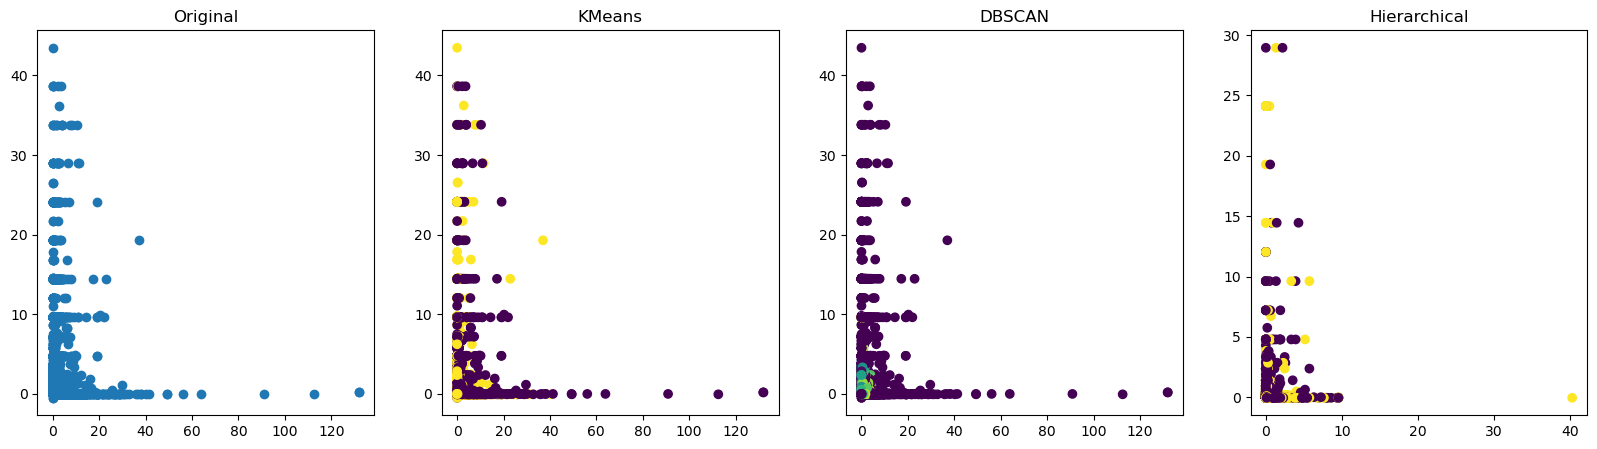

In [46]:

# Visualization
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].scatter(df['nkill'], df['nperps'])
ax[0].set_title('Original')

ax[1].scatter(df['nkill'], df['nperps'], c=df['KMeans_labels'])
ax[1].set_title('KMeans')

ax[2].scatter(df['nkill'], df['nperps'], c=df['DBSCAN_labels'])
ax[2].set_title('DBSCAN')
try:
    ax[3].scatter(dfh['nkill'], dfh['nperps'], c=dfh['Hierarchical_labels'])
    ax[3].set_title('Hierarchical')
except:
    pass
plt.show()


In [47]:
print(len(set(df['KMeans_labels'])), len(set(df['DBSCAN_labels'])), len(set(dfh['Hierarchical_labels'])))

2 859 2
